In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [2]:
%matplotlib qt
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    9.7s remaining:    9.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:   10.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 13.28it/s]

Using control points [0.00000000e+00 0.00000000e+00 9.44862411e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


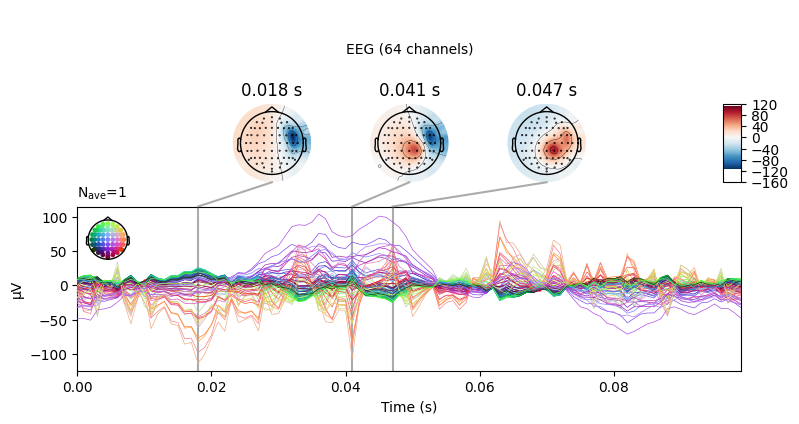

In [49]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=1e99)
settings = dict(number_of_sources=3, extents=(24, 25), duration_of_trial=0.1, target_snr=1e99, amplitudes=100)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
B = evoked.data
S = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Gamma Maximum a-Posteriori

**db** number of sensors  
**ds** number of dipoles  
**n** number of time points  

**B** EEG matrix  
**S** source matrix  
**C** Covariance Matrix  
**Cb** Empirical (Data) Covariance Matrix  
**Sigma_b** Model Covariance Matrix  
**Sigma_s** Source Covariance Matrix  
**Sigma_e** Noise Covariance Matrix  


**E-Step**: find mean and cov of S given gamma_hat  
**M-Step**: update gammas  


In [ ]:
# Parameters
alpha = 1e-6

# Some initialization
L = deepcopy(leadfield)
db, n = B.shape
ds = L.shape[1]

# some helper functions
def frob(x):
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    return np.sqrt(np.trace(x@x.T))

# Common average reference
B -= B.mean(axis=0)
L -= L.mean(axis=0)
# L /= np.linalg.norm(L, axis=0)
# Source Components
C = []
for i in range(ds):
    Ci = np.zeros((ds, ds))
    Ci[i,i] = 1
    C.append( Ci )
# Data Covariance Matrix
Cb = B @ B.T
gammas = np.ones(ds)
sigma_e = alpha * np.identity(db)  
sigma_s = np.identity(ds) # identity leads to weighted minimum L2 Norm solution
sigma_b = sigma_e + L @ sigma_s @ L.T
# r = np.ones(ds)  # THIS IS prob wrong

In [ ]:
max_iter = 50
sigma_b_inv = np.linalg.inv(sigma_b)

for k in range(max_iter):
    old_gammas = deepcopy(gammas)
    print(i, ": ", np.linalg.norm(gammas), " atoms")
    
    # term_1 = (gammas[i]/np.sqrt(n)) * np.sqrt(np.sum((L.T @ sigma_b_inv @ B )**2, axis=1))
    term_1 = (gammas/np.sqrt(n)) * np.sqrt(np.sum((L.T @ sigma_b_inv @ B )**2, axis=1))
    term_2 = 1 / np.diagonal(np.sqrt((L.T @ sigma_b_inv @ L )))
    
    gammas = term_1 * term_2
    if np.linalg.norm(gammas) == 0:
        gammas = old_gammas
        break
    # gammas /= np.linalg.norm(gammas)

gammas_final = gammas / gammas.max()
sigma_s_hat = np.diag(gammas_final) @ sigma_s  #  np.array([gammas_final[i] * C[i] for i in range(ds)])
S = sigma_s_hat @ L.T @ np.linalg.inv(sigma_e + L @ sigma_s_hat @ L.T) @ B

#  Source-Space Maximum A Posteriori

In [ ]:
# Parameters
alpha = 1e-6
p = 0

# Some initialization
L = deepcopy(leadfield)
db, n = B.shape
ds = L.shape[1]

# Common average reference
B -= B.mean(axis=0)
L -= L.mean(axis=0)

# Data Covariance Matrix
gammas = np.ones(ds)
sigma_e = alpha * np.identity(db)  
sigma_s = np.identity(ds) # identity leads to weighted minimum L2 Norm solution
sigma_b = sigma_e + L @ sigma_s @ L.T
# r = np.ones(ds)  # THIS IS prob wrong

max_iter = 50
sigma_b_inv = np.linalg.inv(sigma_b)

for k in range(max_iter):
    old_gammas = deepcopy(gammas)
    print(i, ": ", np.linalg.norm(gammas), " atoms")
    # for i in range(ds):
    #     l_i = L[:, i][:, np.newaxis]
    #     gammas[i] = ((1/n) * np.sqrt(np.sum(( gammas[i] * l_i.T @ sigma_b_inv @ B )**2 )))**((2-p)/2)

    gammas = ((1/n) * np.sqrt(np.sum(( np.diag(gammas) @ L.T @ sigma_b_inv @ B )**2, axis=1)))**((2-p)/2)

    if np.linalg.norm(gammas) == 0:
        gammas = old_gammas
        break
    # gammas /= np.linalg.norm(gammas)

gammas_final = gammas / gammas.max()
sigma_s_hat = np.diag(gammas_final) @ sigma_s  #  np.array([gammas_final[i] * C[i] for i in range(ds)])
S = sigma_s_hat @ L.T @ np.linalg.inv(sigma_e + L @ sigma_s_hat @ L.T) @ B

# Variational Bayes: Mean-Field

In [ ]:
# Parameters
alpha = 1e-6
p = 0

# Some initialization
L = deepcopy(leadfield)
db, n = B.shape
ds = L.shape[1]

# Common average reference
B -= B.mean(axis=0)
L -= L.mean(axis=0)

# Data Covariance Matrix
gammas = np.ones(ds)
sigma_e = alpha * np.identity(db)  
sigma_s = np.identity(ds) # identity leads to weighted minimum L2 Norm solution
sigma_b = sigma_e + L @ sigma_s @ L.T
# r = np.ones(ds)  # THIS IS prob wrong

max_iter = 50
sigma_b_inv = np.linalg.inv(sigma_b)

for k in range(max_iter):
    old_gammas = deepcopy(gammas)
    print(i, ": ", np.linalg.norm(gammas), " atoms")
    # for i in range(ds):
    #     l_i = L[:, i][:, np.newaxis]
    #     gammas[i] = ((1/n) * np.sqrt(np.sum(( gammas[i] * l_i.T @ sigma_b_inv @ B )**2 )))**((2-p)/2)

    gammas = ((1/n) * np.sqrt(np.sum(( np.diag(gammas) @ L.T @ sigma_b_inv @ B )**2, axis=1)))**((2-p)/2)

    if np.linalg.norm(gammas) == 0:
        gammas = old_gammas
        break
    # gammas /= np.linalg.norm(gammas)

gammas_final = gammas / gammas.max()
sigma_s_hat = np.diag(gammas_final) @ sigma_s  #  np.array([gammas_final[i] * C[i] for i in range(ds)])
S = sigma_s_hat @ L.T @ np.linalg.inv(sigma_e + L @ sigma_s_hat @ L.T) @ B

# Expectation-Maximization Champagne

In [147]:
from scipy.stats import pearsonr
Y = evoked.data
Y -= Y.mean(axis=0)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()

L = deepcopy(leadfield)
vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)

n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 100
convergence_crit = 1e-99
eps = 1e-6
alpha = 0.00 * max_eig

I = np.identity(n_chans)
gammas = np.ones(n_dipoles)
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
nulled_idc = np.array([])
for i in range(max_iter):
    print(i, gammas.max())
    old_gammas = deepcopy(gammas)
    right_term = (mu_x**2).sum(axis=1) / n_times
    # update gammas
    gammas = np.diagonal(Sigma_x) + right_term
    gammas[gammas<0] = 0
    gammas[np.isnan(gammas)] = 0
    
    # Thresholding
    # gammas /= gammas.max()
    gammas[gammas<eps] = 0
    # new_null_idc = np.where(gammas<eps)[0]
    # if len(new_null_idc) > 0:
    #     nulled_idc = np.unique(np.concatenate([nulled_idc, new_null_idc])).astype(int)
    # if len(nulled_idc) > 0:
    #     gammas[nulled_idc] = 0
    
    # Convergence Check
    gammas_norm = np.linalg.norm(gammas)
    r = pearsonr(gammas, old_gammas)[0]
    # print(gammas_norm, 1-r)
    if gammas_norm == 0 or (1-r) < convergence_crit:
        print("breaking ", gammas_norm, 1-r)
        gammas = old_gammas
        break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    
# update rest
# gammas[nulled_idc] = 0
gammas[gammas<eps] = 0

gammas /= gammas.max()
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y


# stc_ = stc.copy()
# stc_.data[:, 0] = gammas / abs(gammas).max()
# stc_.plot(**pp, brain_kwargs=dict(title="EM-Champagne"))

stc_ = stc.copy()
stc_.data = mu_x / abs(mu_x).max()
stc_.plot(**pp, brain_kwargs=dict(title="EM-Champagne"))


0 1.0


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1 0.9976372112348131
2 0.9951783268020813
3 0.9926277098708788
4 0.9899878151277716
5 0.9872600435168948
6 0.9844451363966114
7 0.9815433881205712
8 0.9785547741787703
9 0.9754790347495756
10 0.972315732348144
11 0.9690642933155559
12 0.9657240386756225
13 0.9622942077120522
14 0.9587739764133201
15 0.9551624722217121
16 0.9514587860803295
17 0.9476619824827542
18 0.9437711080339641
19 0.9397851988941567
20 0.9357032873797293
21 0.9315244079253909
22 0.9272476025604087
23 0.9228719260147757
24 0.9183964505435073
25 0.9138202705371566
26 0.9091425069711842
27 0.9043623117353483
28 0.8994788718753631
29 0.8944914137720589
30 0.8893992072776477
31 0.8842015698244456
32 0.8788978705174287
33 0.8734875342190997
34 0.8679700456325518
35 0.8623449533862685
36 0.8566118741223349
37 0.8507704965878851
38 0.8448205857281323
39 0.8387619867776394
40 0.8325946293452814
41 0.8263185314867019
42 0.8199338037569128
43 0.8134406532343398
44 0.8068393875060598
45 0.8001304186030331
46 0.793314266872413

# EM-Champagne pruned

In [62]:
np.diag(Sigma_x @ Sigma_x.T / n_times).shape

(1284,)

In [78]:
from scipy.stats import pearsonr
Y = evoked.data
Y -= Y.mean(axis=0)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()

L = deepcopy(leadfield)
L -= L.mean(axis=0)
# L = (L.T / np.linalg.norm(L.T, axis=0)).T
vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)

n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 132
convergence_crit = 1e-99
eps = 1e-3
alpha = 0.00 * max_eig

active_set = np.arange(n_dipoles)
I = np.identity(n_chans)
gammas = np.ones(n_dipoles)
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
gidx = np.abs(gammas) > eps
n_active = deepcopy(n_dipoles)
losses = [1e99,]
for i in range(max_iter):
    print(i, gidx.sum())
    old_gammas = deepcopy(gammas)
    old_gidx = deepcopy(gidx)
    old_active_set = deepcopy(active_set)
    
    right_term = (mu_x**2).mean(axis=1)
    # update gammas
    gammas = np.diagonal(Sigma_x) + right_term

    gammas = np.sqrt(np.diag(Sigma_x @ Sigma_x.T) / np.diag(Gamma @ L.T @ Sigma_y_inv @ L))
    # print(gammas.shape)
    # gammas = np.sqrt(gammas)
    gammas[gammas<0] = 0
    gammas[np.isnan(gammas)] = 0
    
    # Pruning
    gidx = np.abs(gammas) > eps
    active_set = active_set[gidx]
    gammas = gammas[gidx]
    # update only active gammas (once set to zero it stays at zero)
    if n_active > len(active_set):
        n_active = active_set.size
        L = L[:, gidx]

    

    # Convergence Check
    # gammas_norm = np.linalg.norm(gammas)
    # r = pearsonr(gammas, old_gammas)[0]
    # print(gammas_norm, 1-r)
    # if gammas_norm == 0:
    #     # print("breaking ", gammas_norm, 1-r)
    #     gammas = old_gammas
    #     break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    
    loss = np.log(np.linalg.norm(Sigma_y)) + np.mean(np.stack([yy[:, np.newaxis].T @ Sigma_y_inv @ yy[:, np.newaxis] for yy in Y.T], axis=0), axis=0)
    print(loss)
    losses.append(abs(loss))

    # if losses[-2] < losses[-1]:
    #     print("breaking")
    #     gammas = old_gammas
    #     gidx = old_gidx
    #     active_set = old_active_set
    #     break
    
    # e_bar = Y - (L @ mu_x)
    # noise_cov = np.sqrt(np.diag(e_bar @ e_bar.T / n_times) / np.diag(Sigma_y_inv))
    # eps = 0.2 * np.mean(np.diag(noise_cov))

# update rest
gammas_full = np.zeros(n_dipoles)
gammas_full[active_set] = gammas

# gammas /= gammas.max()
Gamma = np.diag(gammas_full)
Sigma_y = (alpha**2) * I + leadfield @ Gamma @ leadfield.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ leadfield.T @ Sigma_y_inv @ Y


# stc_ = stc.copy()
# stc_.data[:, 0] = gammas / abs(gammas).max()
# stc_.plot(**pp, brain_kwargs=dict(title="EM-Champagne"))

stc_ = stc.copy()
stc_.data = mu_x / abs(mu_x).max()
stc_.plot(**pp, brain_kwargs=dict(title="EM-Champagne"))


0 1284
[[20.48624222]]
1 1284
[[22.37351266]]
2 1284
[[24.20444757]]
3 1284
[[25.98411883]]
4 1284
[[27.71721988]]
5 1284
[[29.41458698]]
6 1284
[[31.08517444]]
7 1284
[[32.73100933]]
8 1284
[[34.36368638]]
9 1284
[[35.98585842]]
10 1284
[[37.599179]]
11 1284
[[39.20752814]]
12 1284
[[40.80993481]]
13 1284
[[42.4087023]]
14 1284
[[44.00670636]]
15 1284
[[45.6039133]]
16 1284
[[47.19450833]]
17 1284
[[48.78950367]]
18 1284
[[50.38305519]]
19 1284
[[51.97625316]]
20 1284
[[53.56590409]]
21 1284
[[55.15583901]]
22 1284
[[56.75071461]]
23 1284
[[58.34867997]]
24 1284
[[59.93843192]]
25 1284
[[61.5324543]]
26 1284
[[63.12173939]]
27 1284
[[64.70634456]]
28 1284
[[66.30299957]]
29 1284
[[67.89143881]]
30 1284
[[69.48569846]]
31 1284
[[71.07865652]]
32 1284
[[72.67253998]]
33 1284
[[74.26444544]]
34 1284
[[75.85330436]]
35 1284
[[77.44335225]]
36 1284
[[79.03666576]]
37 1284
[[80.63232867]]
38 1284
[[82.22208761]]
39 1284
[[83.8136773]]
40 1284
[[85.403515]]
41 1284
[[86.9952472]]
42 1284
[[8

Using control points [0.15020212 0.18678042 0.45806395]


# Majorization-Minimization Champagne

In [106]:
from scipy.stats import pearsonr
Y = evoked.data
Y -= Y.mean(axis=0)
L = deepcopy(leadfield)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()

vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)

n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 100
convergence_crit = 1e-99
alpha = 0.00 * max_eig
I = np.identity(n_chans)
gammas = np.ones(n_dipoles)

Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y

for i in range(max_iter):
    print(i)
    old_gammas = deepcopy(gammas)
    z_n = np.diagonal(L.T @ Sigma_y_inv @ L)
    upper_term = (mu_x**2).sum(axis=1) / n_times
    # update gammas
    gammas = upper_term / z_n
    gammas[gammas<0] = 0
    gammas = np.sqrt(gammas)
    gammas[np.isnan(gammas)] = 0

    # Convergence Check
    gammas_norm = np.linalg.norm(gammas)
    r = pearsonr(gammas, old_gammas)[0]
    if gammas_norm == 0 or (1-r) < convergence_crit:
        print("breaking")
        gammas = old_gammas
        break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    
# update rest
gammas /= gammas.max()
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y

    
# stc_ = stc.copy()
# stc_.data[:, 0] = gammas / abs(gammas).max()
# stc_.plot(**pp, brain_kwargs=dict(title="MM-Champagne"))

stc_ = stc.copy()
stc_.data = mu_x / abs(mu_x).max()
stc_.plot(**pp, brain_kwargs=dict(title="MM-Champagne"))


0
1


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Using control points [0.00215912 0.01900858 0.68835432]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# LowSNR-MM-Champagne

In [108]:
from scipy.stats import pearsonr
from scipy.sparse import coo_matrix, kron

Y = evoked.data
Y -= Y.mean(axis=0)
L = deepcopy(leadfield)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()
vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)

n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 100
convergence_crit = 1e-99
alpha = 0.00 * max_eig
theta = 0.00 * max_eig
I = np.identity(n_chans)
It = np.identity(n_times)

D = kron(L, It)
gammas = np.ones(n_dipoles)
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y

for i in range(max_iter):
    print(i)
    old_gammas = deepcopy(gammas)
    z_n = np.diagonal(L.T @ Sigma_y_inv @ L)
    upper_term = (mu_x**2).sum(axis=1) / n_times

    # update gammas
    gammas = upper_term / np.diagonal(L.T@L)
    gammas[gammas<0] = 0
    gammas = np.sqrt(gammas)
    gammas[np.isnan(gammas)] = 0

    # Convergence Check
    gammas_norm = np.linalg.norm(gammas)
    r = pearsonr(gammas, old_gammas)[0]
    if gammas_norm == 0 or (1-r) < convergence_crit:
        print("breaking")
        gammas = old_gammas
        break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    
# update rest
gammas /= gammas.max()
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y

    
# stc_ = stc.copy()
# stc_.data[:, 0] = gammas / abs(gammas).max()
# stc_.plot(**pp, brain_kwargs=dict(title="LowSNR-MM-Champagne"))

stc_ = stc.copy()
stc_.data = mu_x / abs(mu_x).max()
stc_.plot(**pp, brain_kwargs=dict(title="LowSNR-MM-Champagne"))


0
1


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Using control points [0.00216956 0.00727667 0.57084477]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# T-EM Champagne

In [139]:
from scipy.stats import pearsonr
Y = evoked.data
Y -= Y.mean(axis=0)
C = Y@Y.T
max_eig = np.linalg.svd(C)[1].max()

L = deepcopy(leadfield)
vec = lambda x: x.reshape(x.shape[0] * x.shape[1], 1)
def frob(x):
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    return np.sqrt(np.trace(x@x.T))
n_chans, n_dipoles = L.shape
n_times = Y.shape[1]

# Initialize Variables
max_iter = 1000
convergence_crit = 1e-99
alpha = 0.00 * max_eig
theta = 0.00 * max_eig
I = np.identity(n_chans)
gammas = np.ones(n_dipoles)

Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
B_hat = B_hat = np.stack([(mu_x[nn, np.newaxis].T * mu_x[nn, np.newaxis]) / gammas[nn] for nn in range(n_dipoles)], axis=0).sum(axis=0) + theta*It
B = B_hat / frob(B_hat)
for i in range(max_iter):
    print(i)
    old_gammas = deepcopy(gammas)
    right_term = np.diagonal(mu_x @ np.linalg.inv(B) @ mu_x.T)
    # update gammas
    gammas = np.diagonal(Sigma_x) + right_term
    gammas[gammas<0] = 0
    gammas[np.isnan(gammas)] = 0
    
    # Convergence Check
    gammas_norm = np.linalg.norm(gammas)
    r = pearsonr(gammas, old_gammas)[0]
    # print(gammas_norm, 1-r)
    if gammas_norm == 0 or (1-r) < convergence_crit:
        print("breaking ", gammas_norm, 1-r)
        gammas = old_gammas
        break
    # update rest
    Gamma = np.diag(gammas)
    Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
    Sigma_y_inv = np.linalg.inv(Sigma_y)
    Sigma_x = Gamma - Gamma @ L.T @ Sigma_y_inv @ L @ Gamma
    mu_x = Gamma @ L.T @ Sigma_y_inv @ Y
    B_hat = B_hat = np.stack([(mu_x[nn, np.newaxis].T * mu_x[nn, np.newaxis]) / gammas[nn] for nn in range(n_dipoles)], axis=0).sum(axis=0) + theta*It
    B = B_hat / frob(B_hat)
    
# update rest
gammas /= gammas.max()
Gamma = np.diag(gammas)
Sigma_y = (alpha**2) * I + L @ Gamma @ L.T
Sigma_y_inv = np.linalg.inv(Sigma_y)
mu_x = Gamma @ L.T @ Sigma_y_inv @ Y


# stc_ = stc.copy()
# stc_.data[:, 0] = gammas / abs(gammas).max()
# stc_.plot(**pp, brain_kwargs=dict(title="T-EM-Champagne"))

stc_ = stc.copy()
stc_.data = mu_x / abs(mu_x).max()
stc_.plot(**pp, brain_kwargs=dict(title="T-EM-Champagne"))


0


c:\Users\Lukas\Envs\invertenv\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


C:\Users\Lukas\AppData\Local\Temp\ipykernel_7516\2017195413.py:54: RuntimeWarning: invalid value encountered in divide
  B_hat = B_hat = np.stack([(mu_x[nn, np.newaxis].T * mu_x[nn, np.newaxis]) / gammas[nn] for nn in range(n_dipoles)], axis=0).sum(axis=0) + theta*It


582
breaking  0.0 nan
Using control points [0.06260566 0.08646986 0.50732722]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.05277    0.07683266 0.52189494]
Using control points [0.10537186 0.13781085 0.42588084]


# Plot

In [ ]:
stc_ = stc.copy()
stc_.data = S / abs(S).max()
stc_.plot(**pp, brain_kwargs=dict(title="Esimated"))

evoked_ = mne.EvokedArray(L @ S, info).set_eeg_reference("average")
evoked_.plot_joint(title="Estimated")